In [93]:
import re
import numpy as np
import pandas as pd
import spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from gensim.parsing.porter import PorterStemmer
from pprint import pprint
from nltk.corpus import stopwords

# Download necessary data and models
import nltk
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')

# Read in the data
df = pd.read_excel('/content/Digital Twin.xlsx', index_col=0)
df = df.drop_duplicates(subset='Abstract', keep='first').reset_index(drop=True)

# Define stop words
stop_words = stopwords.words('english')
stop_words.extend(['research','use','new','article','study','model','define','background','examine','paper',
                   'eaxamination','ivestigate','aim','goal','objective','US','china','result',
                   'measure','measurment','quality','analysis','approach','method','propose','investigate'])

# Define pre-processing functions
def clean_text(text):
    ## Remove emails, numbers, and punctuation
    text = re.sub(r'\S*@\S*\s?', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Lowercase the text
    text = text.lower()
    # Remove new line characters
    text = re.sub(r'\s+', ' ', text)
    # Remove distracting single quotes
    text = re.sub(r"\'", "", text)
    return text

def tokenize(text):
    tokens = simple_preprocess(text, deacc=True, min_len=3)
    return [token for token in tokens if token not in stop_words]

def make_bigrams(texts):
    bigram = Phrases(texts, min_count=10, threshold=50)
    bigram_phraser = Phraser(bigram)
    trigram = Phrases(bigram_phraser[texts], min_count=10, threshold=50)
    trigram_phraser = Phraser(trigram)
    return [trigram_phraser[bigram_phraser[doc]] for doc in texts]

def lemmatize(text, allowed_postags=['NOUN', 'VERB', 'ADJ', 'ADV']):
    doc = nlp(text)
    return [token.lemma_ for token in doc if token.pos_ in allowed_postags and token.lemma_ not in stop_words]

def stem(text):
    p = PorterStemmer()
    return [p.stem(token) for token in text]

# Pre-process the data
df['text'] = df['Abstract'].apply(clean_text)
df['tokens'] = df['text'].apply(tokenize)
df['bigrams'] = make_bigrams(df['tokens'])
df['lemmatized'] = df['bigrams'].apply(lambda x: lemmatize(' '.join(x)))
df['stemmed'] = df['lemmatized'].apply(stem)




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [94]:
import gensim

# Create a list of lists of the cleaned tokens
text = df['stemmed'].tolist()

# Create a dictionary of the cleaned tokens
dictionary = gensim.corpora.Dictionary(text)
print('Total Vocabulary Size:', len(dictionary))

# Filter out words that occur less than 5 documents, or more than 90% of the documents.
dictionary.filter_extremes(no_below=2, no_above=0.7)
print('Total Vocabulary Size after removing:', len(dictionary))

# Create a bag-of-words corpus of the cleaned tokens
corpus = [dictionary.doc2bow(t) for t in text]

Total Vocabulary Size: 14510
Total Vocabulary Size after removing: 6929


In [95]:
from collections import Counter
import matplotlib.pyplot as plt

# Flatten the list of stemmed words
word_list_flattened = [word for sublist in text for word in sublist]

# Count the frequency of each word
word_counts = Counter(word_list_flattened)

# Get the top 20 keywords based on frequency
top_keywords = word_counts.most_common(20)


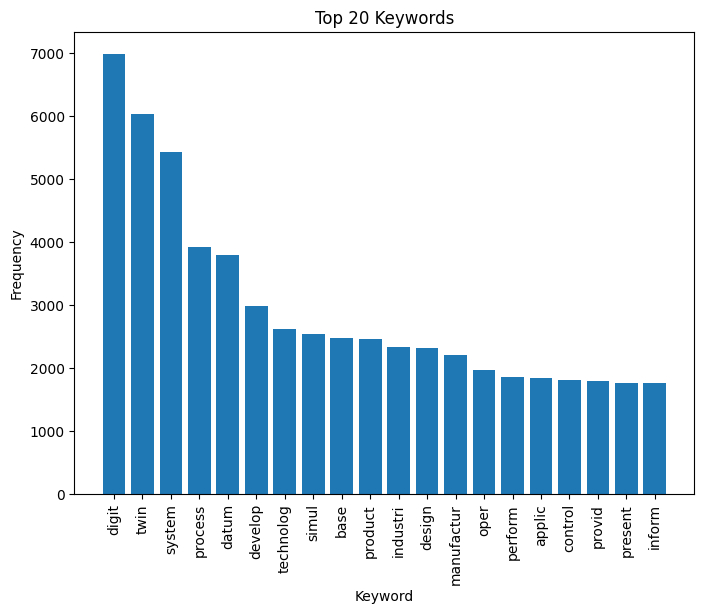

In [96]:
# Create a bar chart of the top keywords
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar([x[0] for x in top_keywords], [x[1] for x in top_keywords])
ax.set_title('Top 20 Keywords')
ax.set_xlabel('Keyword')
ax.set_ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [97]:
import gensim

# Set the number of topics to be generated
num_topics = 10

# Create an LDA model using the bag-of-words corpus and the filtered dictionary
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)

# Print the top 10 words in each topic
for i, topic in lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False):
    print('Topic {}: {}'.format(i, [word[0] for word in topic]))


Topic 0: ['process', 'product', 'control', 'system', 'machin', 'assembl', 'robot', 'develop', 'energi', 'simul']
Topic 1: ['datum', 'base', 'system', 'process', 'develop', 'simul', 'predict', 'structur', 'test', 'differ']
Topic 2: ['process', 'datum', 'system', 'simul', 'develop', 'base', 'predict', 'product', 'network', 'perform']
Topic 3: ['system', 'datum', 'develop', 'technolog', 'engin', 'oper', 'design', 'industri', 'virtual', 'construct']
Topic 4: ['system', 'manufactur', 'industri', 'technolog', 'product', 'design', 'datum', 'develop', 'process', 'inform']
Topic 5: ['system', 'optim', 'patient', 'process', 'simul', 'paramet', 'measur', 'design', 'develop', 'evalu']
Topic 6: ['energi', 'build', 'system', 'base', 'improv', 'perform', 'effici', 'technolog', 'design', 'process']
Topic 7: ['datum', 'process', 'predict', 'system', 'base', 'oper', 'materi', 'present', 'distribut', 'develop']
Topic 8: ['system', 'datum', 'control', 'develop', 'simul', 'inform', 'technolog', 'design', '

In [98]:
import numpy as np
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Set the range of topics to explore
topic_range = list(range(2, 30, 1))

# Set the threshold for perplexity score
perplexity_threshold = 0.05

# Set the threshold for coherence score
coherence_threshold = 0.4

# Initialize variables
coherence_scores = []
perplexity_scores = []
max_coherence_index = -1
optimal_num_topics = -1
perplexity_threshold_index = -1
for num_topics in topic_range:
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=100,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)

    # Compute the coherence score for the LDA model
    coherence_model_lda = CoherenceModel(model=lda_model, texts=text, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()

    # Compute the perplexity score for the LDA model
    perplexity_score = lda_model.log_perplexity(corpus)

    # Store the coherence and perplexity scores
    coherence_scores.append(coherence_score)
    perplexity_scores.append(perplexity_score)

    # Print the coherence and perplexity scores for each topic
    print(f"Number of topics: {num_topics}")
    print(f"Perplexity score: {perplexity_score}")
    print(f"Coherence score: {coherence_score}\n")

    # Track the index of the maximum coherence score
    if coherence_score >= max(coherence_scores[max_coherence_index:], default=0):
        max_coherence_index = topic_range.index(num_topics)

    # Find the optimal number of topics based on perplexity score
    if abs(perplexity_score - np.exp(-perplexity_threshold)) <= perplexity_threshold:
        perplexity_threshold_index = topic_range.index(num_topics)

    # Find the optimal number of topics based on coherence score
    if coherence_score >= coherence_threshold and max_coherence_index != -1 and perplexity_threshold_index != -1:
        optimal_num_topics = topic_range[max_coherence_index:perplexity_threshold_index+1][np.argmax(coherence_scores[max_coherence_index:perplexity_threshold_index+1])]

if optimal_num_topics != -1:
    print('Optimal number of topics:', optimal_num_topics)
else:
    print('Unable to find optimal number of topics')


Number of topics: 2
Perplexity score: -7.332285982264419
Coherence score: 0.326163116053489

Number of topics: 3
Perplexity score: -7.3135198875189324
Coherence score: 0.30686552667523176

Number of topics: 4
Perplexity score: -7.311948644369877
Coherence score: 0.3326073099735026

Number of topics: 5
Perplexity score: -7.330820290571604
Coherence score: 0.37694109073908877

Number of topics: 6
Perplexity score: -7.346265938263495
Coherence score: 0.30637868188754286

Number of topics: 7
Perplexity score: -7.358522834349466
Coherence score: 0.315615439257109

Number of topics: 8
Perplexity score: -7.3772808239859815
Coherence score: 0.34309199562527287

Number of topics: 9
Perplexity score: -7.443851761212611
Coherence score: 0.33687910962874745

Unable to find optimal number of topics


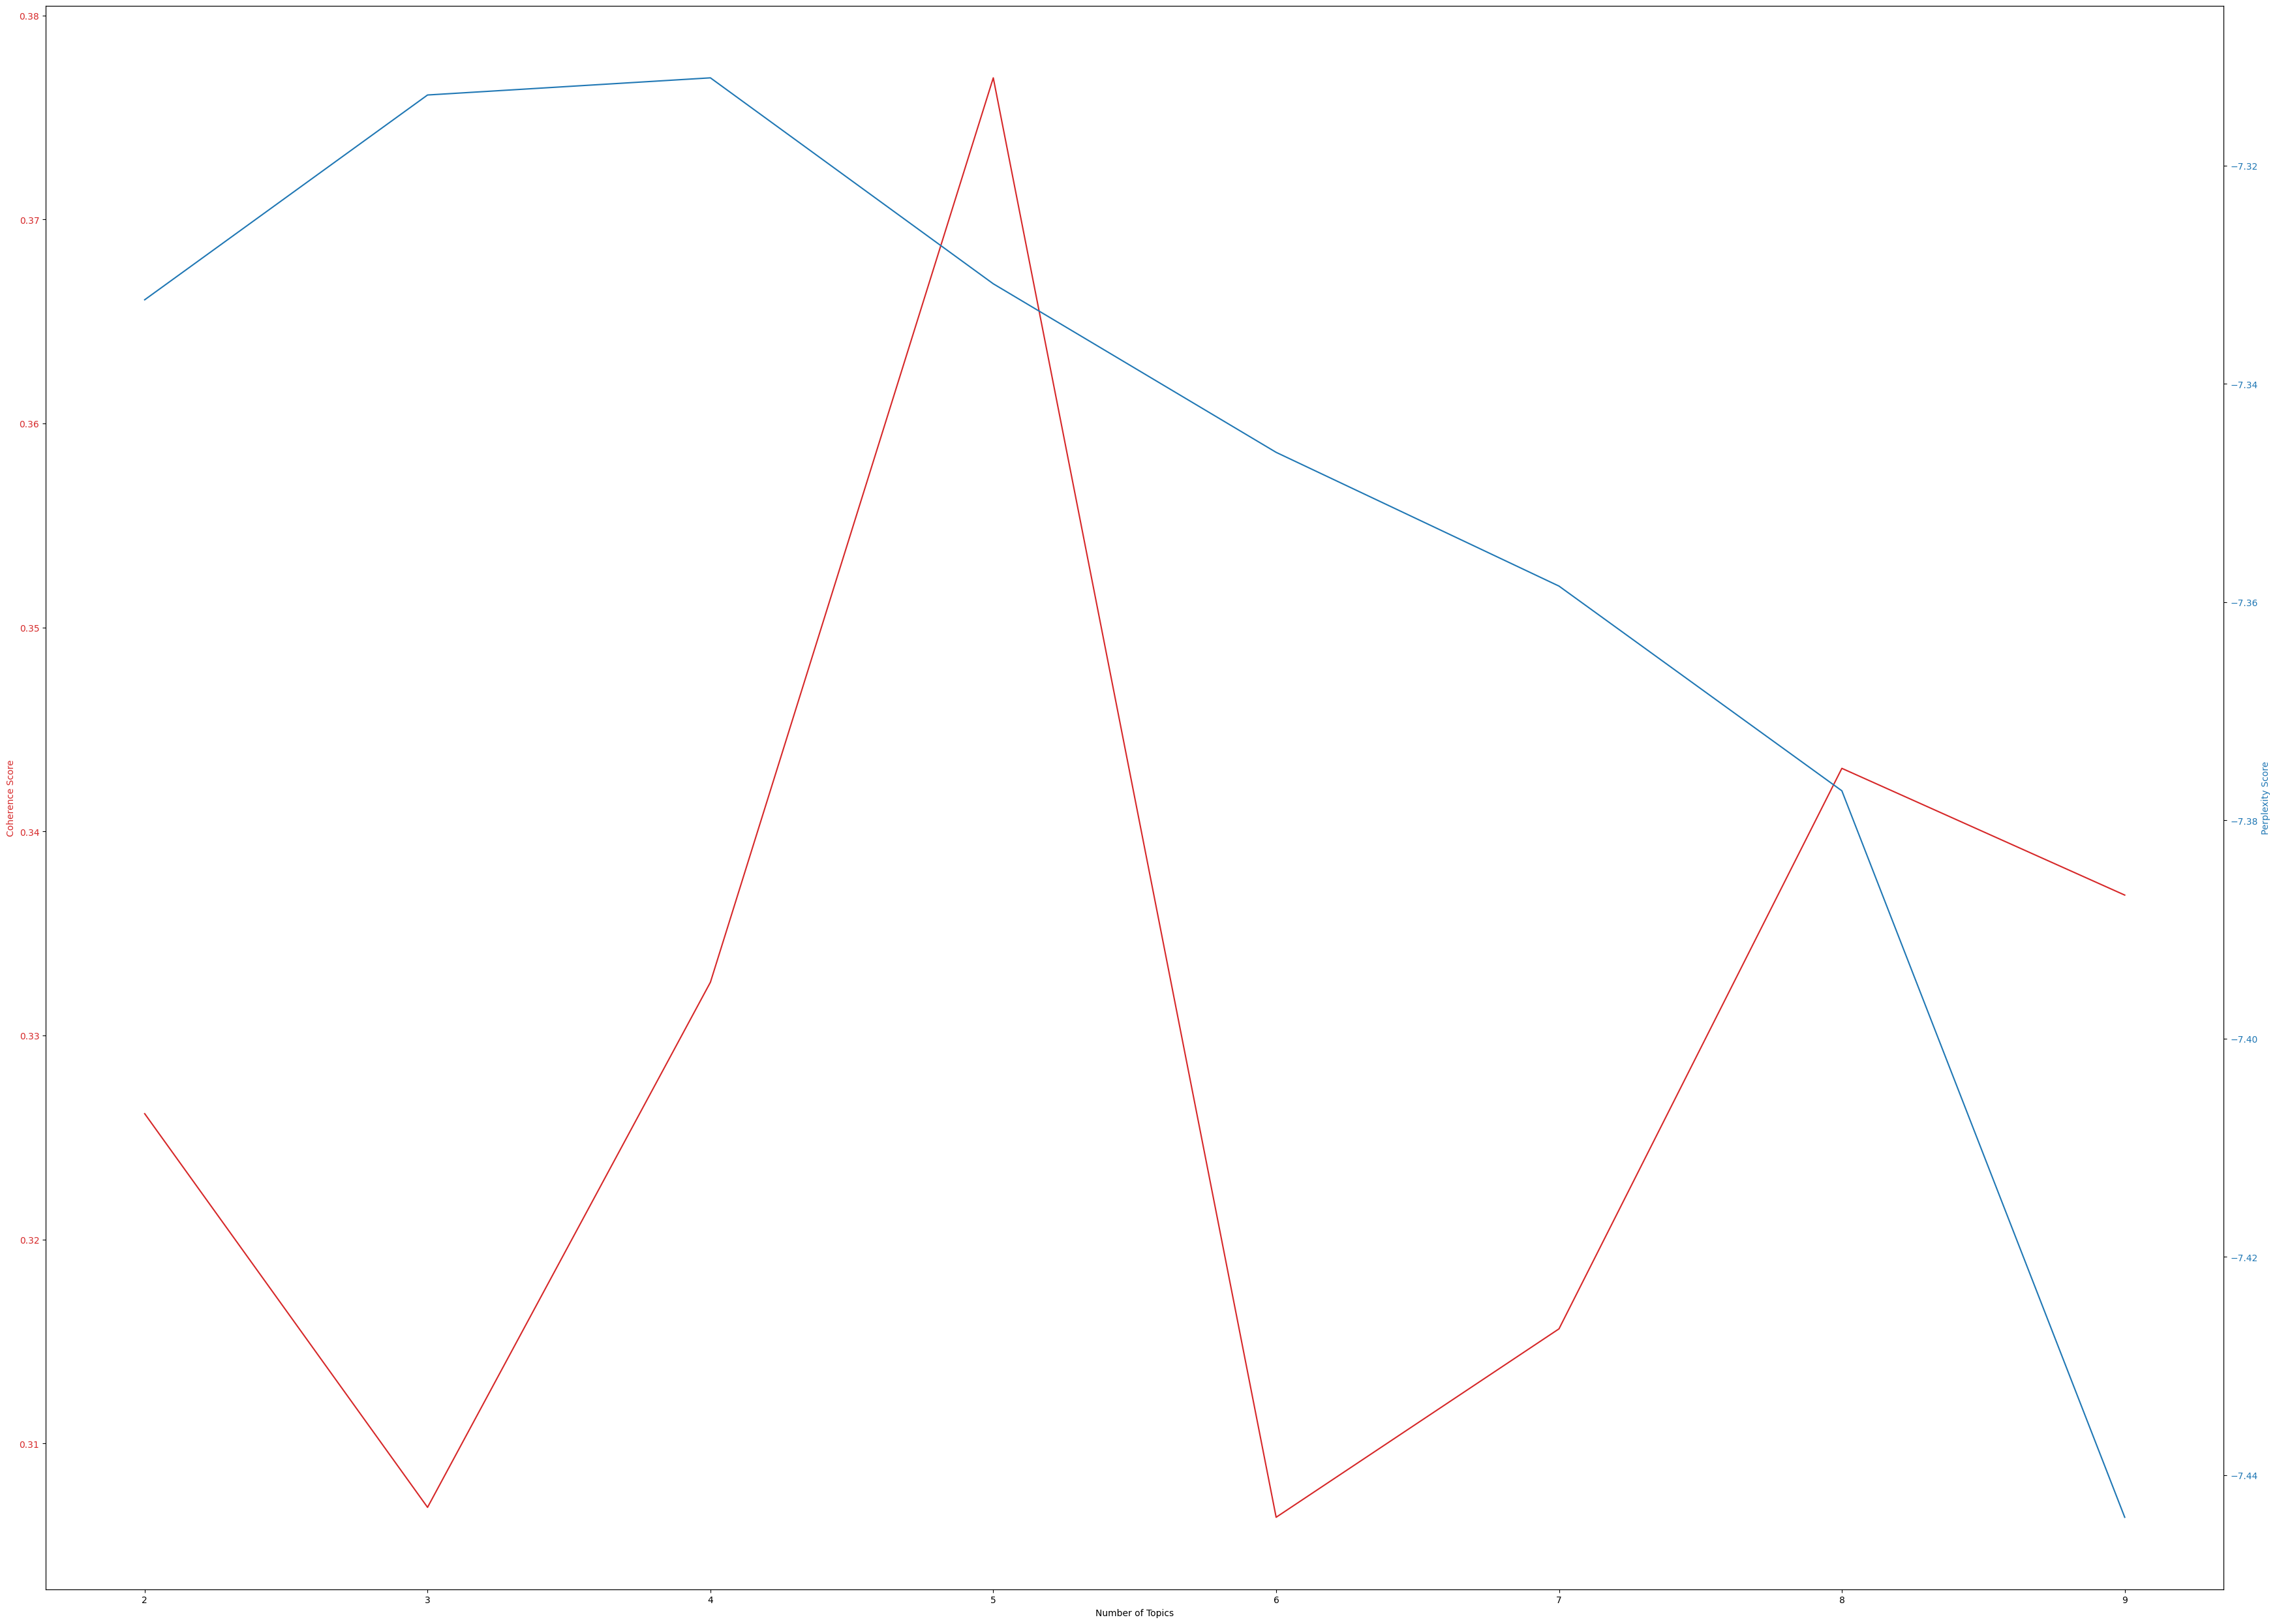

In [99]:
# Plot the results
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence Score', color=color)
ax1.plot(topic_range, coherence_scores, color=color, label='Coherence Score')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Perplexity Score', color=color) 
ax2.plot(topic_range, perplexity_scores, color=color, label='Perplexity Score')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()

In [100]:
# Train an LDA model with the optimal number of topics
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=15,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)
for topic in lda_model.print_topics():
    print(topic)

(0, '0.165*"engin" + 0.141*"individu" + 0.140*"properti" + 0.089*"valuabl" + 0.051*"class" + 0.047*"togeth" + 0.032*"efficaci" + 0.025*"agricultur" + 0.025*"ongo" + 0.021*"disciplin"')
(1, '0.144*"product" + 0.122*"manufactur" + 0.106*"process" + 0.073*"industri" + 0.035*"machin" + 0.031*"intellig" + 0.031*"system" + 0.023*"smart" + 0.020*"part" + 0.019*"autom"')
(2, '0.211*"energi" + 0.064*"spatial" + 0.064*"educ" + 0.059*"batteri" + 0.049*"latter" + 0.042*"student" + 0.040*"results_ind" + 0.039*"convent" + 0.028*"wave" + 0.026*"skill"')
(3, '0.247*"damag" + 0.111*"dt" + 0.058*"proper" + 0.053*"qualit" + 0.037*"encod" + 0.027*"seem" + 0.011*"usecas" + 0.010*"starting_point" + 0.000*"defect" + 0.000*"segment"')
(4, '0.168*"robot" + 0.129*"train" + 0.106*"cell" + 0.051*"motion" + 0.039*"trajectori" + 0.034*"classifi" + 0.030*"movement" + 0.028*"scan" + 0.022*"tree" + 0.022*"track"')
(5, '0.095*"design" + 0.043*"virtual" + 0.032*"physic" + 0.028*"interact" + 0.027*"human" + 0.025*"enviro

In [101]:
lda_model.save('lda_model')
# Load the LDA model from the specified file path
lda_model = LdaModel.load('lda_model')

In [102]:
topics = [[(term, round(wt, 3)) for term, wt in lda_model.show_topic(n, topn=25)] for n in range(0, lda_model.num_topics)]
topics

[[('engin', 0.165),
  ('individu', 0.141),
  ('properti', 0.14),
  ('valuabl', 0.089),
  ('class', 0.051),
  ('togeth', 0.047),
  ('efficaci', 0.032),
  ('agricultur', 0.025),
  ('ongo', 0.025),
  ('disciplin', 0.021),
  ('credibl', 0.018),
  ('uncertainty_quantif', 0.011),
  ('correctli', 0.011),
  ('elev', 0.01),
  ('behalf', 0.009),
  ('trustworthi', 0.008),
  ('verification_valid', 0.006),
  ('imper', 0.003),
  ('customis', 0.003),
  ('reader', 0.002),
  ('plug', 0.001),
  ('clinic', 0.0),
  ('posterior', 0.0),
  ('particl', 0.0),
  ('treatment', 0.0)],
 [('product', 0.144),
  ('manufactur', 0.122),
  ('process', 0.106),
  ('industri', 0.073),
  ('machin', 0.035),
  ('intellig', 0.031),
  ('system', 0.031),
  ('smart', 0.023),
  ('part', 0.02),
  ('autom', 0.019),
  ('compani', 0.017),
  ('flexibl', 0.015),
  ('enterpris', 0.012),
  ('factori', 0.012),
  ('resourc', 0.011),
  ('cp', 0.01),
  ('design', 0.01),
  ('optimis', 0.01),
  ('cyberphys', 0.009),
  ('parallel', 0.009),
  ('p

In [103]:
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 26)],
                         index=['Topic '+str(t) for t in range(1, lda_model.num_topics+1)]).T
topics_df.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15
Term1,engin,product,energi,damag,robot,design,sustain,posit,develop,assembl,market,system,network,process,datum
Term2,individu,manufactur,spatial,dt,train,virtual,mechatron,record,technolog,shadow,shape,oper,ag,base,differ
Term3,properti,process,educ,proper,cell,physic,urban,subject,case,curvatur,size,transit,servic,effect,show
Term4,valuabl,industri,batteri,qualit,motion,interact,environment,combat,inform,geometr,imag,cost,stand,simul,patient
Term5,class,machin,latter,encod,trajectori,human,citi,densiti,applic,cover,surfac,monitor,path,control,structur


In [104]:
pd.set_option('display.max_colwidth', -1)

topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, lda_model.num_topics+1)] )
topics_df

<ipython-input-104-b0dbff8103b2>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Terms per Topic
Topic1,"engin, individu, properti, valuabl, class, togeth, efficaci, agricultur, ongo, disciplin, credibl, uncertainty_quantif, correctli, elev, behalf, trustworthi, verification_valid, imper, customis, reader, plug, clinic, posterior, particl, treatment"
Topic2,"product, manufactur, process, industri, machin, intellig, system, smart, part, autom, compani, flexibl, enterpris, factori, resourc, cp, design, optimis, cyberphys, parallel, plan, integr, conceptu, competit, demand"
Topic3,"energi, spatial, educ, batteri, latter, student, results_ind, convent, wave, skill, subgroup, carbon, teach, loop, cours, learn, expans, artifici, expand, awar, rais, equal, daili, upgrad, expos"
Topic4,"damag, dt, proper, qualit, encod, seem, usecas, starting_point, defect, segment, shm, oma, latent, rail, modal, diagnos, baselin, structural_health_monitoring_shm, assign, deep_learn, brain, earthquak, reconstruct, treatment, particl"
Topic5,"robot, train, cell, motion, trajectori, classifi, movement, scan, tree, track, partial, rout, distanc, drill, rather, weld, respond, human, joint, spars, rehabilit, hazard, optimum, arm, placement"
Topic6,"design, virtual, physic, interact, human, environ, space, activ, experi, task, visual, function, object, user, metavers, platform, significantli, world, real, immers, theori, collabor, natur, creat, manual"
Topic7,"sustain, mechatron, urban, environment, citi, accept, previous_studi, concentr, logist, public, supply_chain, substanti, document, metric, mix, smart_citi, evid, impact, divid, packag, plane, fourth_industrial_revolut, plan, fragment, get"
Topic8,"posit, record, subject, combat, densiti, grid, holist, infer, group, random, nois, presenc, fabric, decentr, minim, web, server, miss, pilot, roadmap, modif, coverag, thread, pursu, opensourc"
Topic9,"develop, technolog, case, inform, applic, provid, economi, integr, gap, industri, build, implement, manag, framework, need, present, len, challeng, open, year, emerg, howev, support, identifi, practic"
Topic10,"assembl, shadow, curvatur, geometr, cover, minim, sequenc, languag, center, cognit, keep, batch, creativ, appear, assur, lean, ubiquit, master, gear, accordingli, tooth, digitaltwin, auxiliari, remanufactur, manual"


In [105]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", colormap="inferno",
               max_font_size=150, random_state=30)
plt.rcParams['figure.figsize'] = [35, 25]
# Create subplots for each topic
for i in range(15):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

Output hidden; open in https://colab.research.google.com to view.